In [1]:
!pip install pandas sweetviz scikit-learn shap joblib flask awsebcli tpot

In [2]:
import pandas as pd
import sweetviz as sv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset from local file
data = pd.read_csv('heart.csv')

# AutoEDA with Sweetviz
report = sv.analyze(data)
report.show_html('heart_disease_sweetviz_report.html')

# Data Cleaning (if necessary)
# Check for missing values
print(data.isnull().sum())

# Feature Engineering
categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal']
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Scaling
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Split data
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                                             |      | [  0%]   00:00 -> (? left)

Report heart_disease_sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [3]:
from tpot import TPOTClassifier
from sklearn.metrics import classification_report
import joblib

# Initialize TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42, n_jobs=-1)

# Fit TPOT
tpot.fit(X_train, y_train)

# Access the best pipeline
exported_pipeline = tpot.fitted_pipeline_

# Evaluate
y_pred = exported_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the best pipeline
joblib.dump(exported_pipeline, 'best_model.pkl')

# Save X_train columns for reindexing in the Flask app
import pickle
with open('columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8346088435374149

Generation 2 - Current best internal CV score: 0.842687074829932

Generation 3 - Current best internal CV score: 0.842687074829932

Generation 4 - Current best internal CV score: 0.842687074829932

Generation 5 - Current best internal CV score: 0.8470238095238095

Best pipeline: MLPClassifier(MinMaxScaler(input_matrix), alpha=0.01, learning_rate_init=0.001)
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



Using 242 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

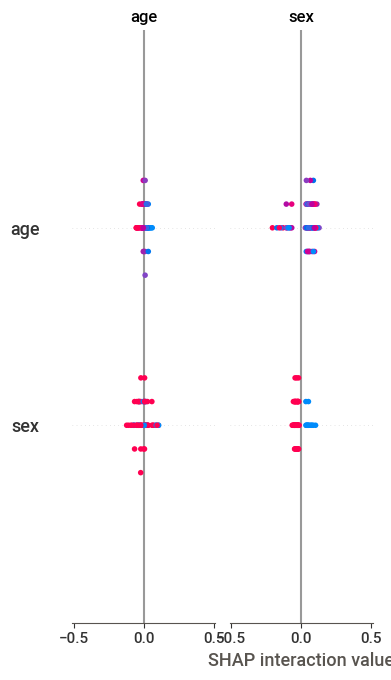

In [4]:
# Identify the classifier in the pipeline
classifier_step_name = list(exported_pipeline.named_steps.keys())[-1]
classifier = exported_pipeline.named_steps[classifier_step_name]

# Initialize SHAP explainer
import shap

if hasattr(classifier, 'predict_proba'):
    if 'tree' in classifier.__class__.__name__.lower():
        explainer = shap.TreeExplainer(classifier)
    else:
        explainer = shap.KernelExplainer(classifier.predict_proba, X_train)
else:
    explainer = shap.KernelExplainer(classifier.predict, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test)